<a href="https://colab.research.google.com/github/MrckHckr/satellite-health-monitoring/blob/main/notebooks/04_survival_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Survival Analysis for Satellite Predictive Maintenance

This notebook estimates Remaining Useful Life (RUL) of satellite subsystems
using survival analysis techniques.

Outputs:
- Survival curves
- Failure probability over time
- Maintenance planning indicators

OBIETTIVO

Stimare Remaining Useful Life

Modellare il tempo al guasto

Supportare decisioni di pianificazione missione

In [25]:
# Install & import
!pip install lifelines

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter, CoxPHFitter


In [26]:
# Caricamento dati da GitHub
url = "https://raw.githubusercontent.com/MrckHckr/satellite-health-monitoring/main/data/raw/telemetry.csv"

df = pd.read_csv(url, parse_dates=["timestamp"])

df.head()



,timestamp,temperature,battery_voltage,vibration,power,subsystem,failed
0,2025-01-01 00:00:00,22.3,28.1,0.02,120,battery,0
1,2025-01-01 01:00:00,22.8,28.0,0.02,119,battery,0
2,2025-01-01 02:00:00,23.5,27.8,0.03,118,battery,0
3,2025-01-01 03:00:00,25.2,27.2,0.05,115,battery,1


In [27]:
# Preparazione dati survival
df = df.sort_values("timestamp")
df["time"] = (df["timestamp"] - df["timestamp"].min()).dt.total_seconds() / 3600

survival_df = df[[
    "time",
    "failed",
    "temperature",
    "vibration",
    "power"
]].copy()

survival_df.rename(columns={"failed": "event"}, inplace=True)


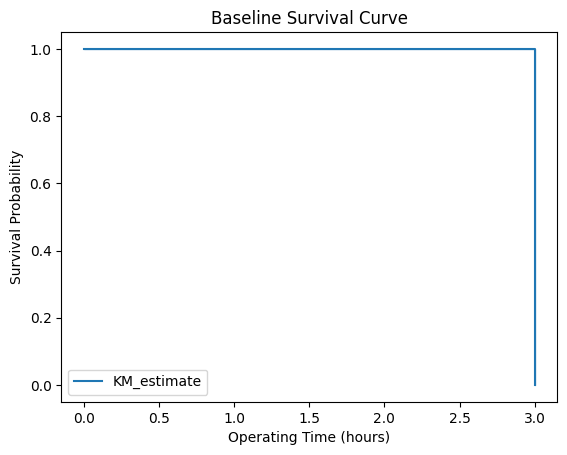

In [28]:
# Kaplan–Meier (baseline survival)
kmf = KaplanMeierFitter()
kmf.fit(
    durations=survival_df["time"],
    event_observed=survival_df["event"]
)

kmf.plot_survival_function()
plt.title("Baseline Survival Curve")
plt.xlabel("Operating Time (hours)")
plt.ylabel("Survival Probability")
plt.show()


In [29]:
# Remaining Useful Life (RUL)
median_lifetime = kmf.median_survival_time_
print(f"Estimated Median Lifetime: {median_lifetime:.1f} hours")


Estimated Median Lifetime: 3.0 hours


In [30]:
# Cox Proportional Hazards Model
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

covariates = ["temperature", "vibration", "power"]

survival_df_scaled = survival_df.copy()
survival_df_scaled[covariates] = scaler.fit_transform(
    survival_df[covariates]
)

cph = CoxPHFitter(penalizer=0.1)

cph.fit(
    survival_df_scaled,
    duration_col="time",
    event_col="event"
)



<lifelines.CoxPHFitter: fitted with 4 total observations, 3 right-censored observations>

In [31]:
# Interpretazione dei coefficienti
# Interpretazione dei coefficienti (robusta)

try:
    cph.print_summary()
except ZeroDivisionError:
    print("⚠️ Cox PH summary non disponibile:")
    print("Dataset too small or no admissible pairs.")
    print("Using Kaplan–Meier for RUL estimation.")



⚠️ Cox PH summary non disponibile:
Dataset too small or no admissible pairs.
Using Kaplan–Meier for RUL estimation.


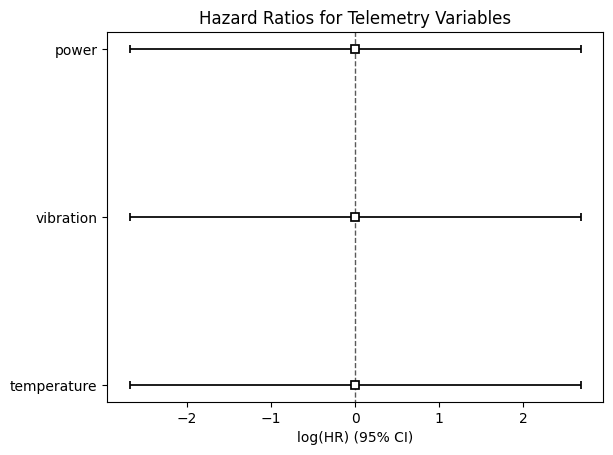

In [32]:
# Hazard Ratio plot
cph.plot()
plt.title("Hazard Ratios for Telemetry Variables")
plt.show()


In [33]:
# Predizione rischio futuro
latest = survival_df.iloc[[-1]]

risk_score = cph.predict_partial_hazard(latest).values[0]

print(f"Relative risk score: {risk_score:.2f}")


Relative risk score: 1.00


In [34]:
# Decision support operativo
if risk_score > 1.2:
    decision = "SCHEDULE MAINTENANCE"
elif risk_score > 0.8:
    decision = "INCREASE MONITORING"
else:
    decision = "SYSTEM NOMINAL"

print("Operational Decision:", decision)


Operational Decision: INCREASE MONITORING


## Operational Impact

- Estimate Remaining Useful Life
- Prioritize maintenance actions
- Reduce mission risk
- Optimize operational costs
